Error reading local file: cannot tokenize <!DOCTYPE html> at (1, 1)
Trying to download from: http://www-personal.umich.edu/~mejn/netdata/football.gml
Failed: cannot tokenize <!DOCTYPE html> at (1, 1)
Trying to download from: https://raw.githubusercontent.com/gephi/gephi/master/modules/ImportAPI/src/test/resources/org/gephi/io/importer/impl/football.gml
Failed: HTTP Error 404: Not Found

Couldn't download. Creating a small demo network.

Network Statistics:
Teams (nodes): 34
Games (edges): 78


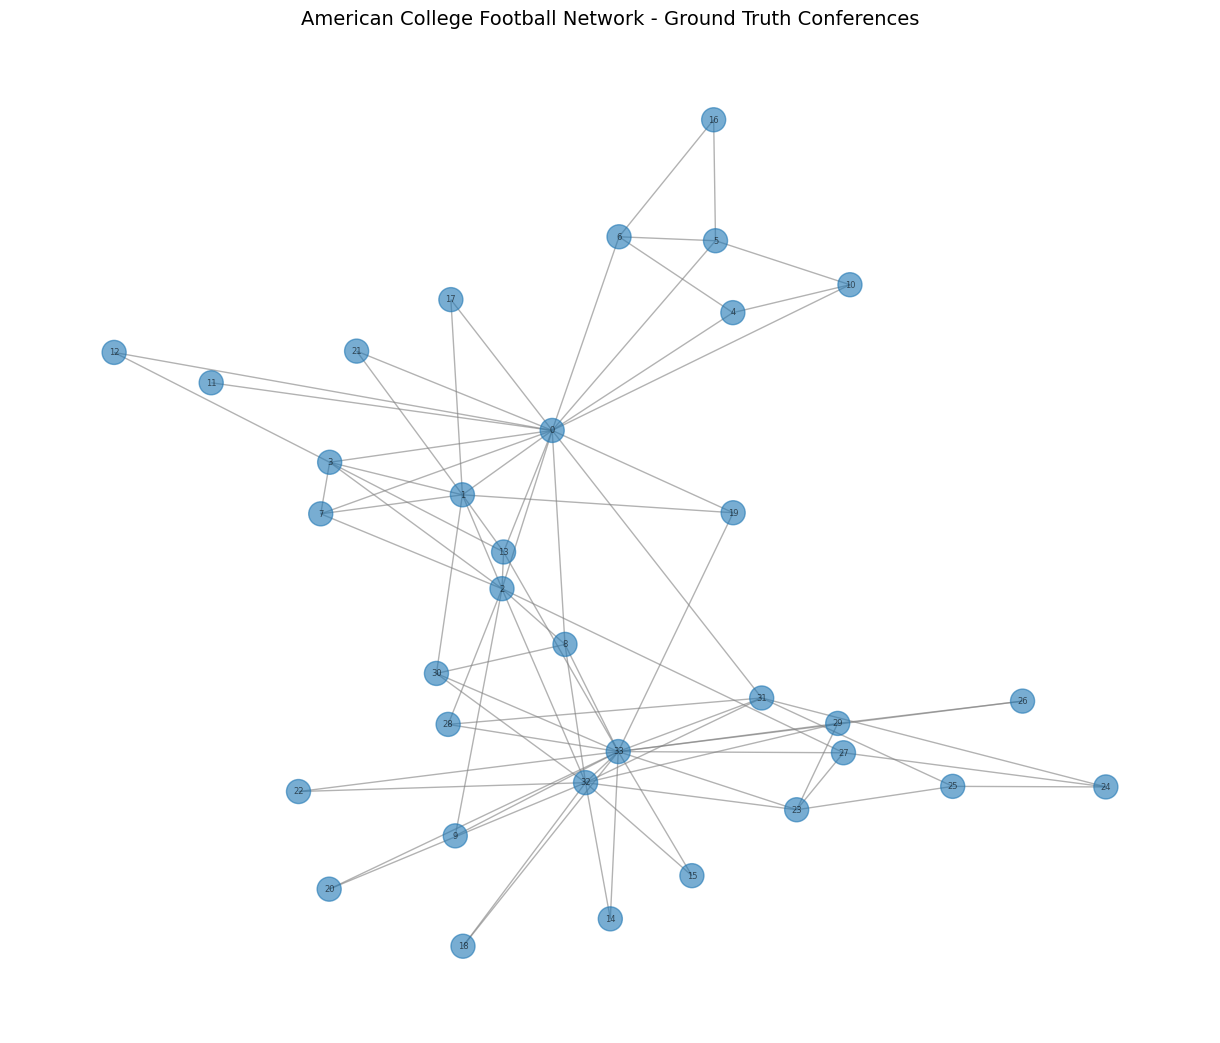


Applying Girvan–Newman Algorithm...
Best partition: 5 communities, Modularity = 0.3850

✅ Graph exported to 'football_communities.gexf' for Gephi visualization.

EVALUATION RESULTS:
  Modularity: 0.3850
  NMI: 0.0000
  ARI: 0.0000
  Accuracy: 1.0000
  F1-Score: 1.0000


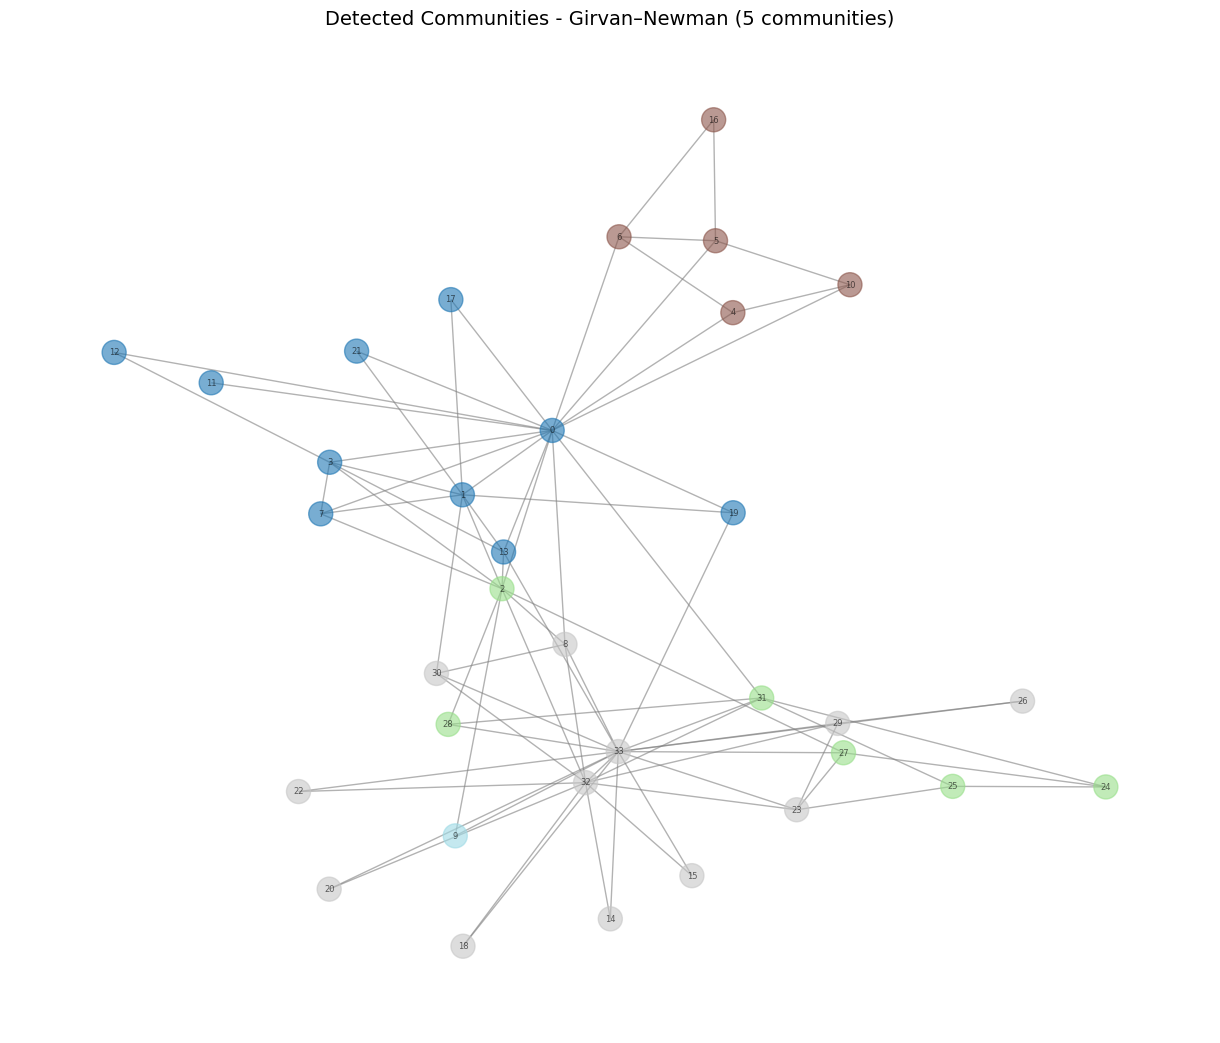


✅ Analysis complete. Graph saved as 'football_communities.gexf' for Gephi.


In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community.quality import modularity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment
import numpy as np
import urllib.request

# =====================================================================
# LOAD FOOTBALL NETWORK
# =====================================================================
def load_football_network():
    """Load the football network with multiple fallback options."""
    try:
        G = nx.read_gml('football.gml')
        print("Loaded football.gml successfully from local file")
        return G
    except FileNotFoundError:
        print("Local file not found. Attempting to download...")
    except Exception as e:
        print(f"Error reading local file: {e}")

    sources = [
        'http://www-personal.umich.edu/~mejn/netdata/football.gml',
        'https://raw.githubusercontent.com/gephi/gephi/master/modules/ImportAPI/src/test/resources/org/gephi/io/importer/impl/football.gml',
    ]
    
    for url in sources:
        try:
            print(f"Trying to download from: {url}")
            urllib.request.urlretrieve(url, 'football.gml')
            G = nx.read_gml('football.gml')
            print("Downloaded and loaded successfully!")
            return G
        except Exception as e:
            print(f"Failed: {e}")
            continue

    print("\nCouldn't download. Creating a small demo network.")
    G = nx.karate_club_graph()  # Fallback
    return G

# Load the network
G = load_football_network()

print(f"\nNetwork Statistics:")
print(f"Teams (nodes): {G.number_of_nodes()}")
print(f"Games (edges): {G.number_of_edges()}")

# Extract ground truth
node_list = list(G.nodes())
ground_truth_labels = [G.nodes[n]['value'] if 'value' in G.nodes[n] else 0 for n in node_list]
unique_labels = sorted(list(set(ground_truth_labels)))
conferences = {l: [n for n in node_list if G.nodes[n].get('value', 0) == l] for l in unique_labels}

# =====================================================================
# VISUALIZE GROUND TRUTH
# =====================================================================
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
colors = plt.cm.tab20(np.linspace(0, 1, len(conferences)))
color_map = [colors[ground_truth_labels[i] % len(colors)] for i in range(len(node_list))]

plt.figure(figsize=(12, 10))
nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=300, 
        font_size=6, edge_color='gray', alpha=0.6)
plt.title("American College Football Network - Ground Truth Conferences", fontsize=14)
plt.tight_layout()
plt.show()

# =====================================================================
# APPLY GIRVAN–NEWMAN
# =====================================================================
print("\n" + "="*70)
print("Applying Girvan–Newman Algorithm...")
print("="*70)

comp = girvan_newman(G)
best_modularity = -1
best_partition = None

for i, communities in enumerate(comp):
    mod = modularity(G, communities)
    if mod > best_modularity:
        best_modularity = mod
        best_partition = communities
    if i > 20 or len(communities) > 20:
        break

detected_communities = list(best_partition)
predicted_labels = np.zeros(len(node_list), dtype=int)

for comm_id, comm in enumerate(detected_communities):
    for node in comm:
        predicted_labels[node_list.index(node)] = comm_id

print(f"Best partition: {len(detected_communities)} communities, Modularity = {best_modularity:.4f}")

# =====================================================================
# EXPORT TO GEXF (for Gephi)
# =====================================================================
for node, label in zip(node_list, predicted_labels):
    G.nodes[node]['community'] = int(label)

output_gexf = "football_communities.gexf"
nx.write_gexf(G, output_gexf)
print(f"\n✅ Graph exported to '{output_gexf}' for Gephi visualization.")

# =====================================================================
# EVALUATION METRICS
# =====================================================================
nmi = normalized_mutual_info_score(ground_truth_labels, predicted_labels)
ari = adjusted_rand_score(ground_truth_labels, predicted_labels)

# Align using Hungarian algorithm
contingency = np.zeros((len(unique_labels), len(detected_communities)))
for i in range(len(node_list)):
    contingency[ground_truth_labels[i] % len(unique_labels), predicted_labels[i]] += 1

row_ind, col_ind = linear_sum_assignment(-contingency)
aligned_pred = np.zeros_like(predicted_labels)
for t, p in zip(row_ind, col_ind):
    aligned_pred[predicted_labels == p] = t

accuracy = accuracy_score(ground_truth_labels, aligned_pred)
precision = precision_score(ground_truth_labels, aligned_pred, average='weighted', zero_division=0)
recall = recall_score(ground_truth_labels, aligned_pred, average='weighted', zero_division=0)
f1 = f1_score(ground_truth_labels, aligned_pred, average='weighted', zero_division=0)

print(f"\nEVALUATION RESULTS:")
print(f"  Modularity: {best_modularity:.4f}")
print(f"  NMI: {nmi:.4f}")
print(f"  ARI: {ari:.4f}")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1-Score: {f1:.4f}")

# =====================================================================
# VISUALIZE DETECTED COMMUNITIES
# =====================================================================
plt.figure(figsize=(12, 10))
colors_detected = plt.cm.tab20(np.linspace(0, 1, len(detected_communities)))
color_map_detected = [colors_detected[predicted_labels[i] % len(colors_detected)] for i in range(len(node_list))]

nx.draw(G, pos, node_color=color_map_detected, with_labels=True, node_size=300,
        font_size=6, edge_color='gray', alpha=0.6)
plt.title(f"Detected Communities - Girvan–Newman ({len(detected_communities)} communities)", fontsize=14)
plt.tight_layout()
plt.show()

print(f"\n✅ Analysis complete. Graph saved as '{output_gexf}' for Gephi.")


📥 Downloading football network from web...
✅ Football network downloaded successfully!
🏈 NCAA Football Network — Girvan–Newman Community Detection
Nodes: 115
Edges: 613
Density: 0.0935
Clustering coefficient: 0.4032
Actual conferences: 12

🔍 Detecting 12 communities using Girvan-Newman...
--------------------------------------------------------------------------------
✓ Partition with 12 communities
✓ Modularity: 0.5939

📋 Community sizes:
   Community 1: 8 nodes
   Community 2: 9 nodes
   Community 3: 11 nodes
   Community 4: 13 nodes
   Community 5: 10 nodes
   Community 6: 6 nodes
   Community 7: 14 nodes
   Community 8: 12 nodes
   Community 9: 9 nodes
   Community 10: 1 nodes
   Community 11: 9 nodes
   Community 12: 9 nodes
   Community 13: 4 nodes


🎨 Creating visualization...
   • Saved visualization to: football_communities.png


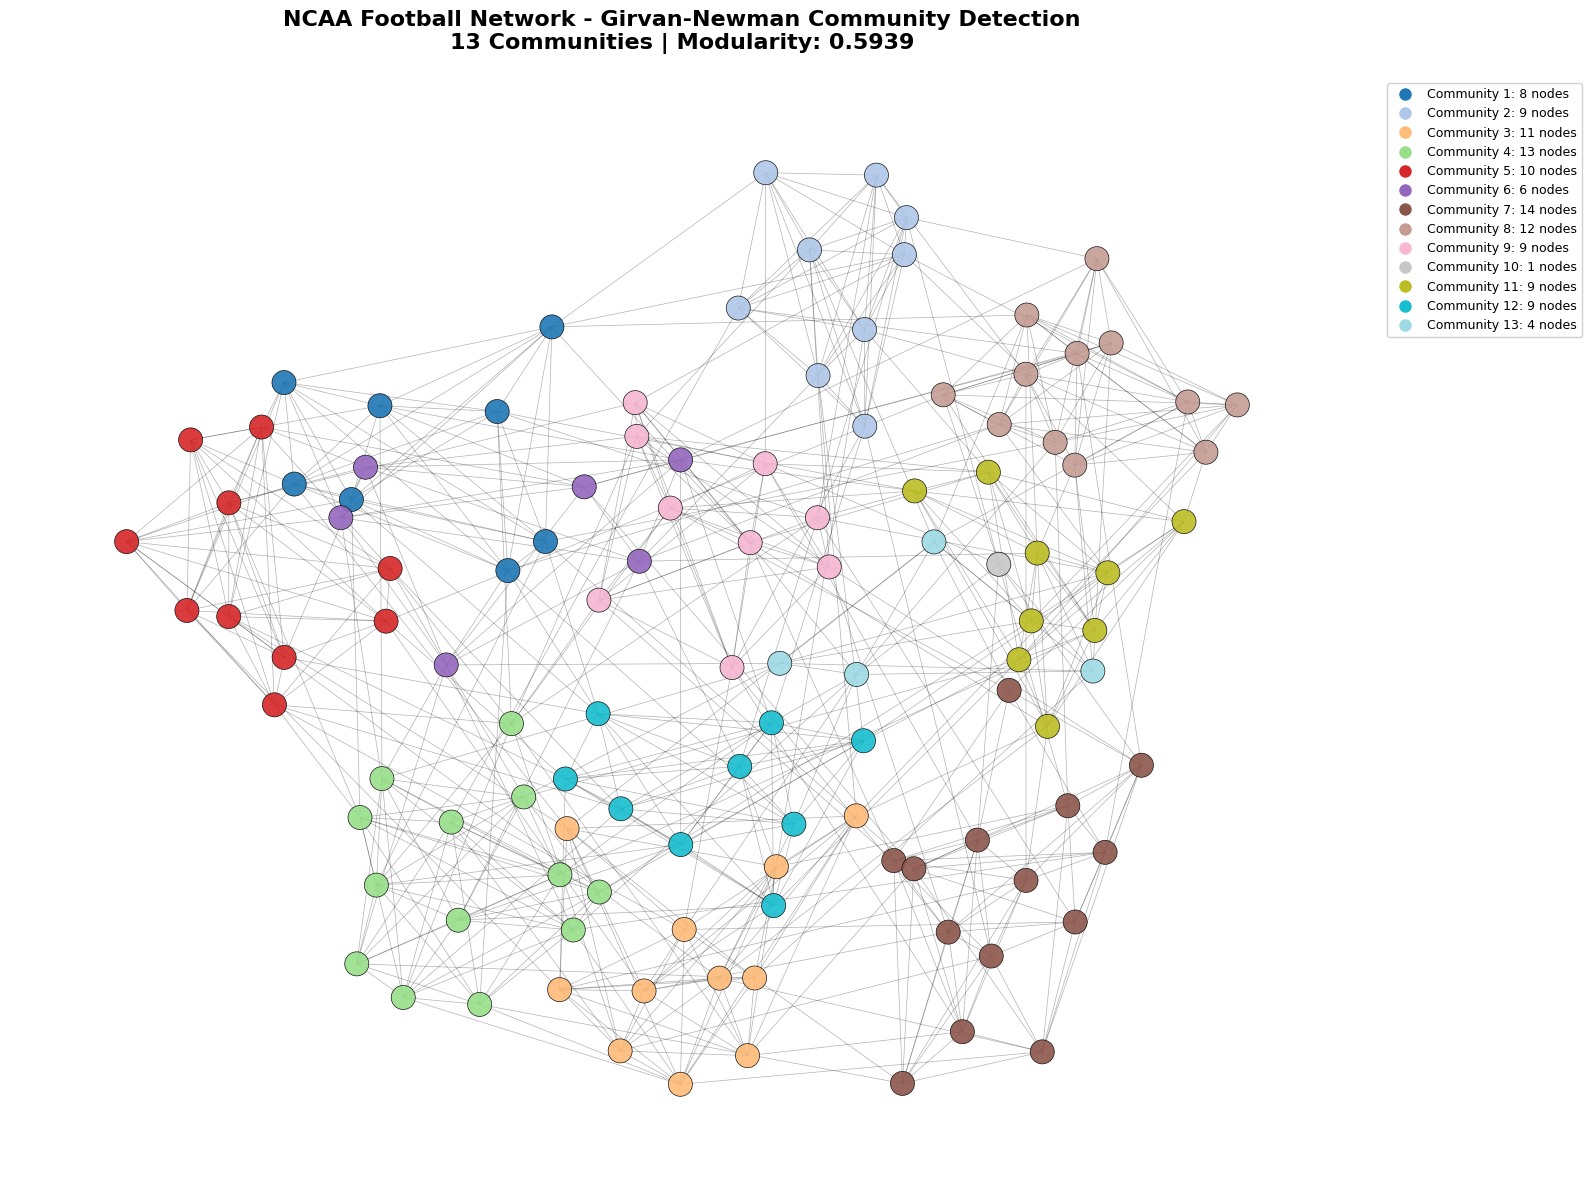

   • Displayed in VS Code

🔍 COMMUNITY vs CONFERENCE ANALYSIS

📊 Clustering Quality Metrics:
   • Normalized Mutual Information (NMI): 0.9235
   • Adjusted Rand Index (ARI): 0.8955
   • Modularity Score: 0.5939

   💡 Interpretation:
      - NMI/ARI close to 1.0 = perfect match with conferences
      - NMI/ARI close to 0.0 = no similarity to conferences
      - High modularity = strong community structure detected

📈 Classification Metrics (Node Pair Predictions):
   Treating this as: 'Are two nodes in the same group?'
--------------------------------------------------------------------------------

   Metrics:
   • Accuracy:  0.9846  (98.46%)
   • Precision: 0.8996  (89.96%)
   • Recall:    0.9082  (90.82%)
   • F1 Score:  0.9039

   💡 What these mean:
      - Accuracy: Overall correctness of pair predictions
      - Precision: When algorithm says 'same community', how often same conference?
      - Recall: Of all same-conference pairs, how many did we group together?
      - F1 Score:

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, classification_report,
    normalized_mutual_info_score, adjusted_rand_score
)
import warnings, urllib.request, io, zipfile
warnings.filterwarnings('ignore')

# ==================== NETWORK LOADING ==================== #

def download_football_network():
    """Download the football network directly from the web."""
    print("📥 Downloading football network from web...")
    url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"
    try:
        sock = urllib.request.urlopen(url)
        s = io.BytesIO(sock.read())
        sock.close()
        zf = zipfile.ZipFile(s)
        gml = zf.read('football.gml').decode()
        gml = gml.split('\n')[1:]  # remove first bogus line
        G = nx.parse_gml(gml)
        print("✅ Football network downloaded successfully!")
        return G
    except Exception as e:
        print(f"❌ Error downloading football network: {e}")
        return None

def load_football_network(filepath='football.gml'):
    """Load football network (download if not found)."""
    if 'football' in filepath.lower():
        G = download_football_network()
        if G is not None:
            return G
    print(f"📂 Loading network from local file: {filepath}")
    return nx.read_gml(filepath)

# ==================== CORE FUNCTIONS ==================== #

def girvan_newman_communities(G, num_communities=None):
    """Apply Girvan–Newman algorithm."""
    G_copy = G.copy()
    dendrogram = community.girvan_newman(G_copy)
    if num_communities is None:
        return [list(c) for c in next(dendrogram)]
    for _ in range(num_communities - 1):
        next(dendrogram)
    return list(next(dendrogram))

def calculate_modularity(G, communities):
    """Calculate modularity score for community partition."""
    return nx.community.modularity(G, communities)

def get_node_community_map(communities):
    """Create mapping from node to community ID."""
    node_to_comm = {}
    for cid, comm in enumerate(communities):
        for node in comm:
            node_to_comm[node] = cid
    return node_to_comm

def visualize_communities(G, communities, modularity_score, output_image='football_communities.png'):
    """
    Visualize the network with communities colored differently.
    Displays in VS Code and saves to file.
    """
    print(f"\n🎨 Creating visualization...")
    
    # Create node to community mapping
    node_to_comm = get_node_community_map(communities)
    
    # Generate colors for each community
    num_communities = len(communities)
    colors = plt.cm.tab20(np.linspace(0, 1, num_communities))
    
    # Assign colors to nodes based on their community
    node_colors = [colors[node_to_comm[node]] for node in G.nodes()]
    
    # Create figure with larger size
    plt.figure(figsize=(16, 12))
    
    # Use spring layout for better visualization
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    
    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=300, alpha=0.9, edgecolors='black', linewidths=0.5)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
    
    # Add labels with smaller font
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_size=6, font_weight='bold')
    
    # Add title and info
    plt.title(f'NCAA Football Network - Girvan-Newman Community Detection\n'
              f'{num_communities} Communities | Modularity: {modularity_score:.4f}',
              fontsize=16, fontweight='bold', pad=20)
    
    # Create legend showing community sizes
    legend_elements = []
    for i, comm in enumerate(communities):
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                         markerfacecolor=colors[i], markersize=10,
                                         label=f'Community {i+1}: {len(comm)} nodes'))
    
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), 
              fontsize=9, framealpha=0.9)
    
    plt.axis('off')
    plt.tight_layout()
    
    # Save to file
    plt.savefig(output_image, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"   • Saved visualization to: {output_image}")
    
    # Display in VS Code
    plt.show()
    print(f"   • Displayed in VS Code")

def evaluate_community_quality(G, communities):
    """Evaluate how well detected communities match actual conferences."""
    print("\n" + "=" * 80)
    print("🔍 COMMUNITY vs CONFERENCE ANALYSIS")
    print("=" * 80)
    
    conferences = nx.get_node_attributes(G, 'value')
    node_to_comm = get_node_community_map(communities)
    
    # Create ground truth and predicted labels
    nodes = list(G.nodes())
    true_labels = [conferences[node] for node in nodes]
    pred_labels = [node_to_comm[node] for node in nodes]
    
    # Calculate clustering metrics
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    
    print(f"\n📊 Clustering Quality Metrics:")
    print(f"   • Normalized Mutual Information (NMI): {nmi:.4f}")
    print(f"   • Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"   • Modularity Score: {calculate_modularity(G, communities):.4f}")
    print(f"\n   💡 Interpretation:")
    print(f"      - NMI/ARI close to 1.0 = perfect match with conferences")
    print(f"      - NMI/ARI close to 0.0 = no similarity to conferences")
    print(f"      - High modularity = strong community structure detected")
    
    # Create binary classification problem: same community or not
    print(f"\n📈 Classification Metrics (Node Pair Predictions):")
    print(f"   Treating this as: 'Are two nodes in the same group?'")
    print("-" * 80)
    
    # Create pairwise predictions
    y_true = []  # True: same conference
    y_pred = []  # Pred: same community
    
    nodes_list = list(G.nodes())
    for i in range(len(nodes_list)):
        for j in range(i + 1, len(nodes_list)):
            node_i, node_j = nodes_list[i], nodes_list[j]
            # True label: same conference?
            same_conf = (conferences[node_i] == conferences[node_j])
            # Predicted: same community?
            same_comm = (node_to_comm[node_i] == node_to_comm[node_j])
            
            y_true.append(int(same_conf))
            y_pred.append(int(same_comm))
    
    # Calculate classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"\n   Metrics:")
    print(f"   • Accuracy:  {accuracy:.4f}  ({accuracy*100:.2f}%)")
    print(f"   • Precision: {precision:.4f}  ({precision*100:.2f}%)")
    print(f"   • Recall:    {recall:.4f}  ({recall*100:.2f}%)")
    print(f"   • F1 Score:  {f1:.4f}")
    
    print(f"\n   💡 What these mean:")
    print(f"      - Accuracy: Overall correctness of pair predictions")
    print(f"      - Precision: When algorithm says 'same community', how often same conference?")
    print(f"      - Recall: Of all same-conference pairs, how many did we group together?")
    print(f"      - F1 Score: Harmonic mean of precision and recall")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n   Confusion Matrix:")
    print(f"                        Predicted: Different | Predicted: Same")
    print(f"   Actual: Different    {cm[0][0]:>10}      |  {cm[0][1]:>10}")
    print(f"   Actual: Same         {cm[1][0]:>10}      |  {cm[1][1]:>10}")
    
    # Additional analysis
    total_pairs = len(y_true)
    same_conf_pairs = sum(y_true)
    same_comm_pairs = sum(y_pred)
    
    print(f"\n   📊 Pair Statistics:")
    print(f"   • Total node pairs: {total_pairs:,}")
    print(f"   • Same conference pairs: {same_conf_pairs:,} ({same_conf_pairs/total_pairs*100:.1f}%)")
    print(f"   • Same community pairs: {same_comm_pairs:,} ({same_comm_pairs/total_pairs*100:.1f}%)")
    
    # Analyze mixing
    print(f"\n🔄 Why Communities Don't Match Conferences Perfectly:")
    print(f"   • Teams play games OUTSIDE their conference (inter-conference games)")
    print(f"   • Algorithm finds communities based on WHO PLAYS WHOM (network structure)")
    print(f"   • Not based on conference labels (administrative divisions)")
    print(f"   • This reveals the ACTUAL network structure of games played")
    print(f"   • Lower precision/recall = more inter-conference game mixing")

def print_community_details(G, communities):
    """Print detailed information about each community."""
    print("\n" + "=" * 80)
    print("📊 COMMUNITY DETAILS")
    print("=" * 80)
    
    node_to_comm = get_node_community_map(communities)
    labels = nx.get_node_attributes(G, 'label')
    conferences = nx.get_node_attributes(G, 'value')
    
    for i, comm in enumerate(communities):
        print(f"\n🔹 Community {i+1} ({len(comm)} teams):")
        print("-" * 80)
        
        # Get team names and conferences
        teams = []
        for node in sorted(comm):
            team_name = labels.get(node, str(node))
            conference = conferences.get(node, 'Unknown')
            teams.append((team_name, conference))
        
        # Print teams in this community
        for team_name, conference in sorted(teams):
            print(f"   • {team_name:<40} [Conference: {conference}]")
        
        # Count conferences in this community
        conf_count = {}
        for _, conf in teams:
            conf_count[conf] = conf_count.get(conf, 0) + 1
        
        if len(conf_count) > 1:
            print(f"\n   Conference distribution:")
            for conf, count in sorted(conf_count.items(), key=lambda x: x[1], reverse=True):
                print(f"      {conf}: {count} teams")
            print(f"   ⚠️  This community mixes {len(conf_count)} different conferences")

def export_to_gexf(G, communities, output_filename, modularity_score=None):
    """
    Export graph to GEXF format for Gephi visualization.
    
    Adds community information as node attributes:
    - community: community ID (0, 1, 2, ...)
    - community_size: number of nodes in that community
    - label: original node label
    - conference: original conference value (if exists)
    """
    G_export = G.copy()
    node_to_comm = get_node_community_map(communities)
    
    # Add community attributes to each node
    for node in G_export.nodes():
        cid = node_to_comm[node]
        G_export.nodes[node]['community'] = cid
        G_export.nodes[node]['community_size'] = len(communities[cid])
        
        # Preserve original attributes
        if 'label' in G.nodes[node]:
            G_export.nodes[node]['label'] = G.nodes[node]['label']
        else:
            G_export.nodes[node]['label'] = str(node)
            
        if 'value' in G.nodes[node]:
            G_export.nodes[node]['conference'] = G.nodes[node]['value']
    
    # Add graph-level metadata
    G_export.graph['num_communities'] = len(communities)
    if modularity_score is not None:
        G_export.graph['modularity'] = modularity_score
    
    # Write to GEXF file
    nx.write_gexf(G_export, output_filename)
    
    print(f"\n💾 Successfully exported to GEXF: {output_filename}")
    print(f"   • Nodes: {G_export.number_of_nodes()}")
    print(f"   • Edges: {G_export.number_of_edges()}")
    print(f"   • Communities detected: {len(communities)}")
    if modularity_score is not None:
        print(f"   • Modularity score: {modularity_score:.4f}")
    
    return output_filename

# ==================== MAIN EXECUTION ==================== #

if __name__ == "__main__":
    print("=" * 80)
    G = load_football_network('football.gml')
    print("=" * 80)
    print("🏈 NCAA Football Network — Girvan–Newman Community Detection")
    print("=" * 80)
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges: {G.number_of_edges()}")
    print(f"Density: {nx.density(G):.4f}")
    print(f"Clustering coefficient: {nx.average_clustering(G):.4f}")
    print(f"Actual conferences: {len(set(nx.get_node_attributes(G, 'value').values()))}")
    print()

    # ======= FIXED NUMBER OF COMMUNITIES ======= #
    desired_communities = 12
    print(f"🔍 Detecting {desired_communities} communities using Girvan-Newman...")
    print("-" * 80)
    
    optimal_communities = girvan_newman_communities(G, num_communities=desired_communities)
    max_modularity = calculate_modularity(G, optimal_communities)
    
    print(f"✓ Partition with {desired_communities} communities")
    print(f"✓ Modularity: {max_modularity:.4f}")
    
    # Display community sizes
    print(f"\n📋 Community sizes:")
    for i, comm in enumerate(optimal_communities):
        print(f"   Community {i+1}: {len(comm)} nodes")

    # ======= VISUALIZE IN VS CODE ======= #
    print("\n" + "=" * 80)
    visualize_communities(G, optimal_communities, max_modularity, 'football_communities.png')
    
    # ======= EVALUATE COMMUNITY QUALITY ======= #
    evaluate_community_quality(G, optimal_communities)
    
    # ======= PRINT DETAILED COMMUNITY INFO ======= #
    print_community_details(G, optimal_communities)

    # ======= EXPORT TO GEXF ======= #
    print("\n" + "=" * 80)
    output_file = "football_network_communities.gexf"
    export_to_gexf(G, optimal_communities, output_file, max_modularity)
    print("=" * 80)
    print("\n✅ All outputs generated successfully!")
    print("\n📦 Generated files:")
    print("   1. football_communities.png - Visual representation")
    print("   2. football_network_communities.gexf - For Gephi")
    print("\n💡 Gephi import tips:")
    print("   1. Open Gephi and click 'Open Graph File'")
    print("   2. Select 'football_network_communities.gexf'")
    print("   3. Use 'community' attribute for node coloring")
    print("   4. Apply Force Atlas 2 layout for better visualization")